In [14]:
import django
import sys, os

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

import pandas as pd
import numpy as np
import datetime
import statistics

In [6]:
columns = [
    'id',
    'UT_id',
    'authors',
    'content',
    'first_author',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

In [33]:
q = Query.objects.get(pk=1457)

doubletag = Tag.objects.get(pk=1405)

rated_docs = DocOwnership.objects.filter(
    tag__query=1457,relevant__gt=0,tag=doubletag
).values_list('doc__id',flat=True)

ratings = list(Doc.objects.filter(id__in=rated_docs,content__iregex='\w').values(*columns))
for r in ratings:
    d = Doc.objects.get(pk=r['id'])
    cutoff = datetime.datetime(2018,6,1,0,0,0)
    dos = DocOwnership.objects.filter(
        query=q,doc=d,relevant__gt=0,
        date__isnull=False,date__gt=cutoff,tag=doubletag
    ).order_by('user')
    
    try:
        r['majority_rating'] = statistics.mode(dos.values_list('relevant',flat=True))
    except:
        r['majority_rating'] = 0
    
    if not dos.exists():
        continue
    r['ratings'] = dos.count()
    r['first_rated'] = dos.order_by('finish').first().finish
    for i, do in enumerate(dos):
        r[f'rating_{i+1}'] = do.relevant
    continue
    
        
df = pd.DataFrame.from_dict(ratings)

df = df[df['rating_1'].notna()]

#df = df[df['relevant'].isin([1,2])]

#df['relevant'][df['relevant']==2] = 0

df = df.reset_index(drop=True)

df.head()


/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/django/db/models/fields/__init__.py:1421: RuntimeWarning: DateTimeField DocOwnership.date received a naive datetime (2018-06-01 00:00:00) while time zone support is active.
  RuntimeWarning)


,UT_id,authors,content,first_author,first_rated,id,majority_rating,rating_1,rating_2,rating_3,ratings,title,wosarticle__de,wosarticle__wc
0,WOS:A1993LQ17900012,"LI, SY, LI, SY",Triple cereal cropping is an important grain p...,"LI, SY",2019-01-07 16:13:03.597635+00:00,50914,1,1,1,2,3,YIELD STABILITY AND FERTILIZER EFFICIENCY OF L...,TRIPLE CEREAL CROPPING; BARLEY; DOUBLE-CROPPED...,[Soil Science]
1,WOS:000265440700004,"Garg, A, Dhiman, RC, Bhattacharya, S, Shukla, PR",India has reasons to be concerned about climat...,"Garg, A",2018-12-17 18:09:15.258013+00:00,715432,1,1,1,1,3,"Development, Malaria and Adaptation to Climate...",Impact assessment; Development; Climate change...,[Environmental Sciences]
2,WOS:000293236800005,"Bencze, L, Carter, L",It is apparent that many of us live in a hyper...,"Bencze, L",2018-12-17 17:42:10.332651+00:00,497013,1,1,1,1,3,Globalizing Students Acting for the Common Good,globalization; science; education; neoconserva...,[Education & Educational Research]
3,WOS:000229230800003,"Cairns, J","How ironic that, in humankind's quest for sust...","Cairns, J",2018-12-17 18:08:32.099957+00:00,705124,1,1,1,1,3,Biomonitoring: The crucial link between natura...,ecosystems; biomonitoring; sustainability of l...,[Anthropology]
4,WOS:A1995RJ43000001,"SPEHAR, CR",The cerrados of Brazil are typical of low-lati...,"SPEHAR, CR",2018-12-17 16:42:14.361469+00:00,71307,1,1,1,1,3,IMPACT OF STRATEGIC GENES IN SOYBEAN ON AGRICU...,BREEDING; GLYCINE MAX; MATURITY; SOIL TOLERANCE,[Agronomy]


In [34]:
df.shape

(200, 14)

In [46]:
from sklearn.metrics import precision_recall_fscore_support
acc = []
precision = []
recall = []
fscore = []
coders = []
ctype = []

for i in range(df['ratings'].max()):
    agreed = len([x for x in df[f'rating_{i+1}'] == df['majority_rating'] if x])
    agreement = agreed / df.shape[0]
    print(f"Coder {i+1} agreement: {agreement}")
    prf = precision_recall_fscore_support(df['majority_rating'],df[f'rating_{i+1}'], average='binary')
    print(prf)
    acc.append(agreement)
    precision.append(prf[0])
    recall.append(prf[1])
    fscore.append(prf[2])
    coders.append(i)
    ctype.append("human")
    
results = pd.DataFrame({
    'accuracy': acc,
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'coders': coders,
    'ctype': ctype
})    
results.head()

Coder 1 agreement: 0.965
(0.9681528662420382, 0.987012987012987, 0.977491961414791, None)
Coder 2 agreement: 0.965
(0.9622641509433962, 0.9935064935064936, 0.9776357827476039, None)
Coder 3 agreement: 0.925
(1.0, 0.9025974025974026, 0.9488054607508533, None)


,accuracy,precision,recall,fscore,coders,ctype
0,0.965,0.968153,0.987013,0.977492,0,human
1,0.965,0.962264,0.993506,0.977636,1,human
2,0.925,1.000000,0.902597,0.948805,2,human


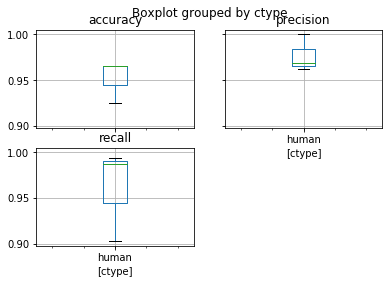

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-50ae794ec632>", line 7, in <module>
    results.to_csv('human_results.csv')
  File "/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/pandas/core/frame.py", line 1745, in to_csv
    formatter.save()
  File "/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/pandas/io/formats/csvs.py", line 156, in save
    compression=self.compression)
  File "/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/pandas/io/common.py", line 400, in _get_handle
    f = open(path_or_buf, mode, encoding=encoding)
FileNotFoundError: [Errno 2] No such file or directory: 'human_results.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/galm/software/django/

FileNotFoundError: [Errno 2] No such file or directory: 'human_results.csv'

In [53]:
import matplotlib.pyplot as plt

results.boxplot(column=['accuracy','precision','recall'],by=["ctype"])

plt.show()

results.to_csv('human_results.csv')

In [37]:
df.to_csv('docs_test.csv')